<a href="https://colab.research.google.com/github/fatenchtioui/Time_series/blob/main/p_timeseries_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

# Dataset

In [ ]:

lien_data="https://raw.githubusercontent.com/nevermind78/Time_series_project/main/datasets/international_airline_passengers.csv"
data= pd.read_csv(lien_data)

In [ ]:
data.head(15)

,time,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


# Analyse

In [ ]:
# Type des attributs
for column in data.columns:
    print(f"The data type for '{column}' column is: {data[column].dtype}")

The data type for 'time' column is: object
The data type for 'passengers' column is: int64


In [ ]:
# calculer les statistique descriptive
data.describe()

,passage
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [ ]:
# change les noms des time par Date et passengers par passage
data=data.rename(columns = {'DATE':'time','passengers':'passage'})

# visualisation

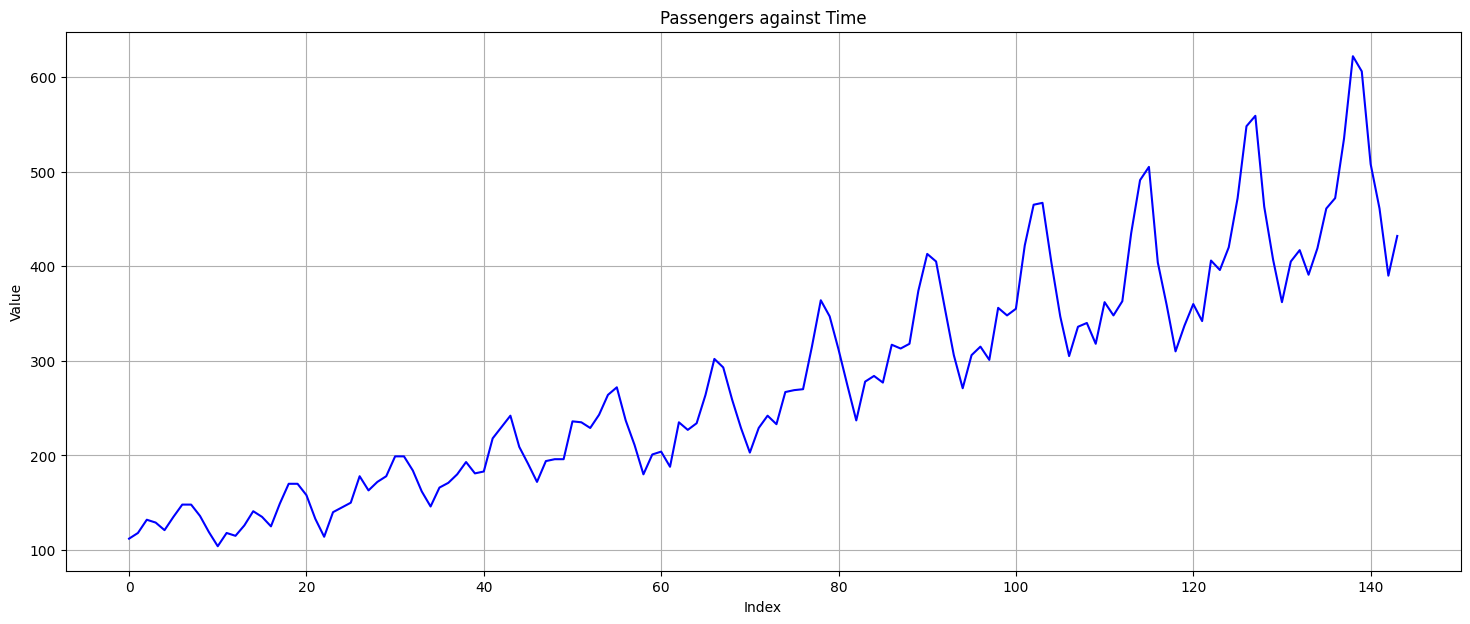

In [ ]:
# plot time plot
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Passengers against Time")
ax.grid()
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    data['passage'],
    color='blue', label='Data');

# Prédiction

In [ ]:
# divise les données
df_train, df_test = train_test_split(data, train_size=0.7, shuffle=False)

# affiche longueur df train
print(f"The length of training dataset is: {len(df_train)}")

# affiche longueur df test
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 100
The length of test dataset is: 44


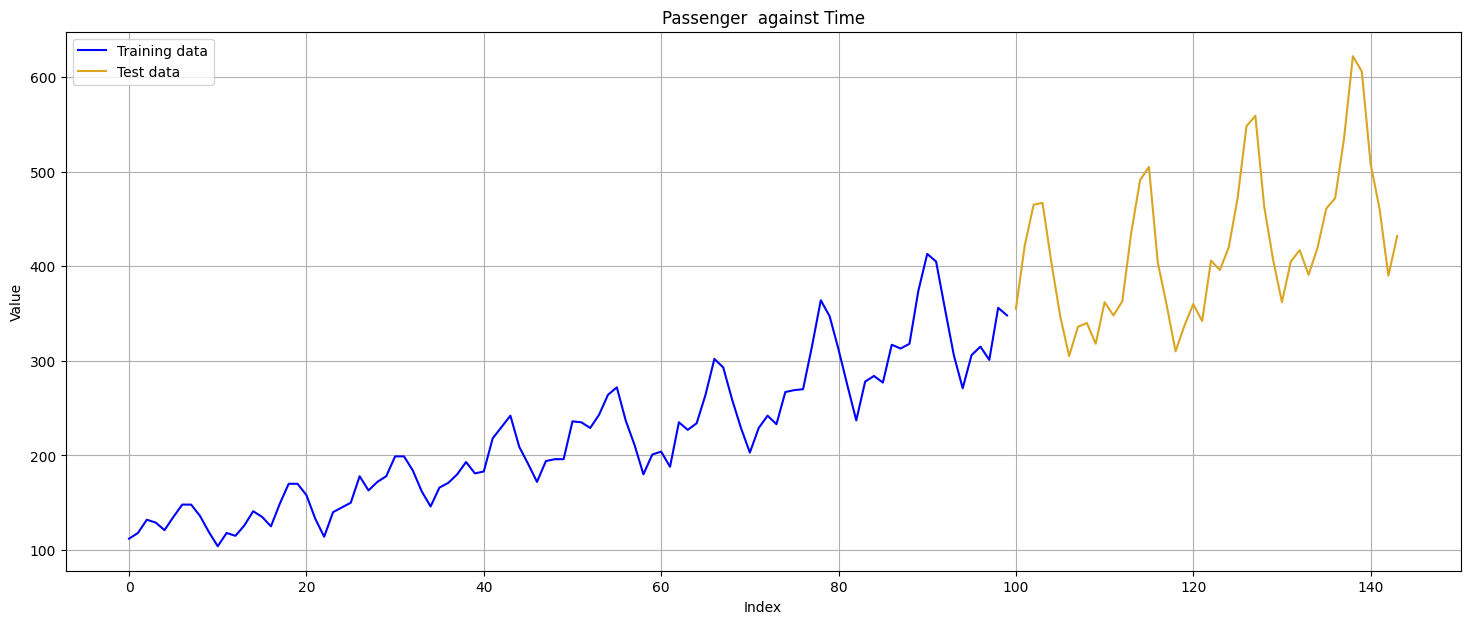

In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Passenger  against Time")
ax.grid()
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['passage'],
    color='blue', label='Training data');
ax.plot(
    df_test['passage'],
    color='goldenrod', label='Test data')
ax.legend();

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['passage'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['passage'].values.reshape(-1,1))

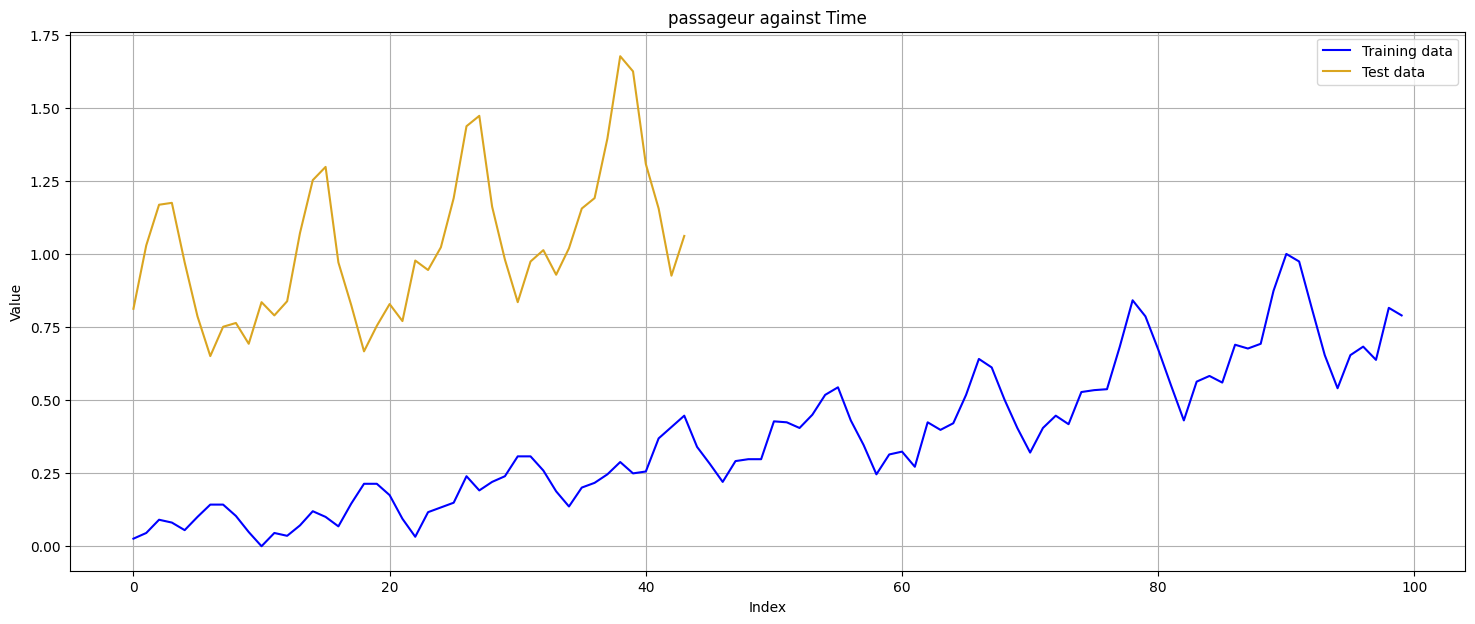

In [ ]:
# plot time plot for training and test dataset
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("passageur against Time")
ax.grid()
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    train_scaled ,
    color='blue', label='Training data');
ax.plot(
    test_scaled,
    color='goldenrod', label='Test data')
ax.legend();

In [ ]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 5)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 5)

# sanity check
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 95
Total samples for y train: 95
Total samples for X test: 39
Total samples for y test: 39


In [ ]:
class PassageurDataset(Dataset):
    """
    Convert input data into torch FloatTensor.
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
# declare batch size
batch_size = 4

# convert into Dataset using customized class
train_Dataset = PassageurDataset(X_sequence_train, y_sequence_train)
test_Dataset = PassageurDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader}

In [ ]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)

    def forward(self, x):
        x = x.view(-1, 1, 5)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

In [ ]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 5
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)

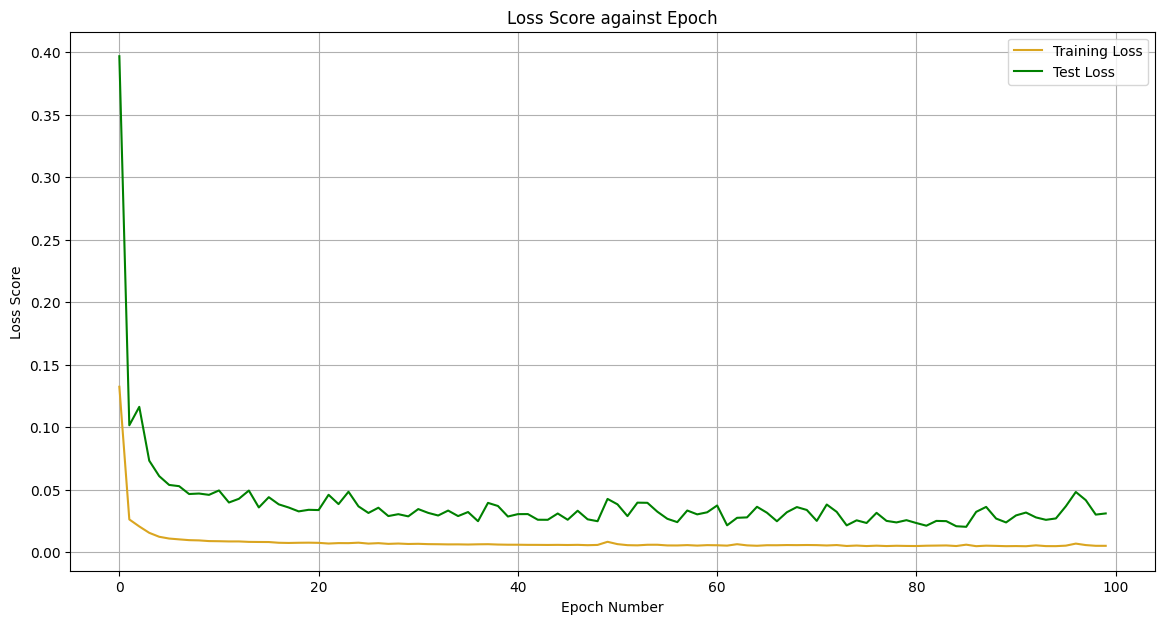

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid()
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

In [ ]:
# model predictions


model.eval()

predictions = []
count = 0


with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())








# convert list into np array and inverse transform it into proper values before feature scaling

predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))



# remove beginning 7 rows of data since at least 7 data are needed to make a prediction

df_test = df_test.iloc[5:]
df_test['preds'] = predictions.squeeze()



# compute MSE


RMSE = mean_squared_error(df_test.preds, df_test.passage, squared=False)
print(f"The RMSE for the model is {RMSE}")


The RMSE for the model is 54.308083748063545


<ipython-input-108-39a9b8f89a78>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = predictions.squeeze()


105    349.643918
106    312.089675
107    304.717292
108    348.655801
109    336.882200
110    310.887267
111    347.226079
112    328.602443
113    350.897657
114    409.064256
115    451.401997
116    448.090838
117    341.565929
118    324.888800
119    308.242282
120    358.620771
121    355.270474
122    332.347618
123    386.486182
124    364.108512
125    393.051551
126    426.585548
127    495.624030
128    485.269375
129    388.732310
130    353.457551
131    350.315727
132    408.484444
133    396.493181
134    365.055373
135    385.761863
136    424.995094
137    429.688511
138    477.948102
139    543.297933
140    515.258252
141    418.521151
142    397.435087
143    372.532075
Name: preds, dtype: float64


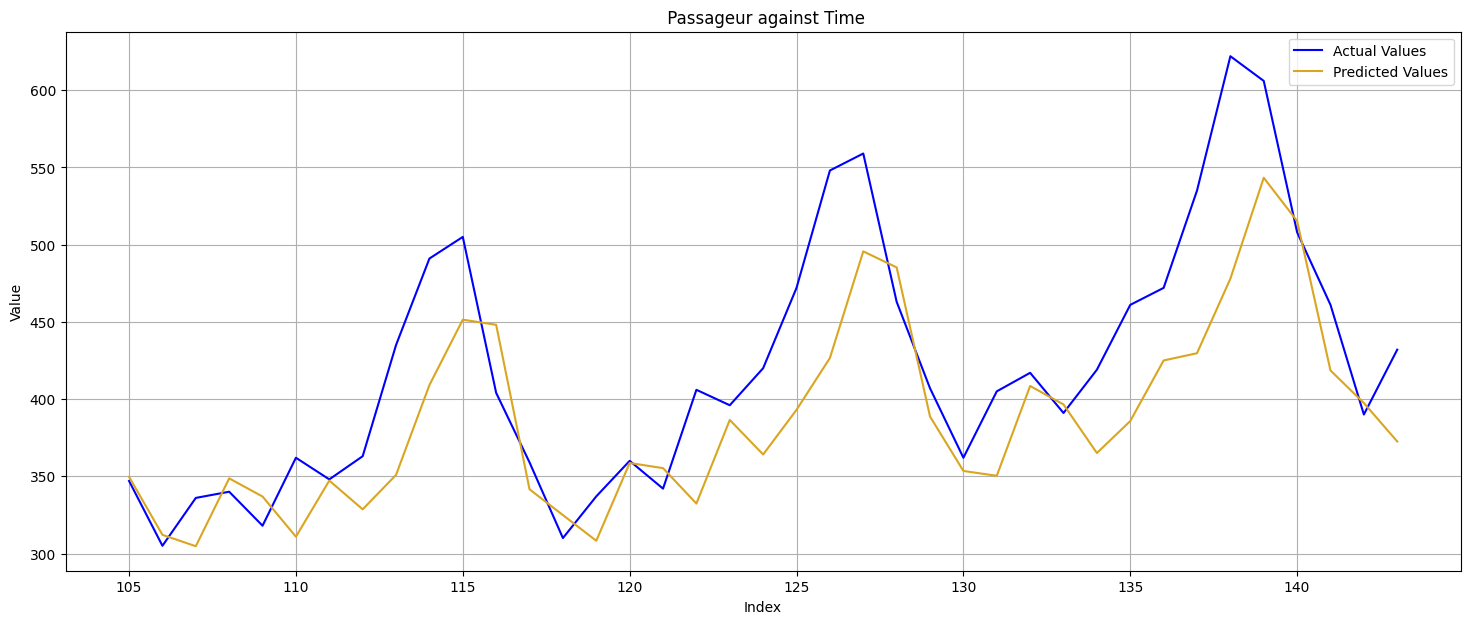

In [ ]:
# print prediction results
print(df_test['preds'])

# plot time plot for predictions and ground truth
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title(" Passageur against Time")
ax.grid()
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['passage'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();



